## FINA 4335 with Marius Popescu
## Project 2

### Instructions

    1. Upload your group's notebook to Canvas, and a PDF of your notebook to Gradescope. The PDF must be exported from JupyterLab via File > Save and Export Notebook As… > PDF
    2. Your notebook must be self-contained (i.e., import data from the web via yfinance or pandas datareader and do not rely on other files)
    3. Tips:
        a) Your goal is to convince me of your conclusions
        b) Remove unnecessary data frame printouts.
        c) Remove code that does not serve a purpose.

#### Import the Necessary Libraries

In [50]:
import datetime as dt
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### PART I

    1. In this question, you will examine the effectiveness of the CAPM model. In order to do this, you will need to download the 'Portfolios_Formed_on_BETA' file from Ken French's website at Dartmouth College. Specifically, you will need to use the third dataset (index [2]), which contains the annual returns on two sets of portfolios formed on the previous year's betas. You will need to use the quintile portfolios (Lo20 through Hi20) for your analysis.
        a. Compute and plot the average annual return for each of the five portfolios. How do you interpret the results?
        b. Compute and plot the value of $1 invested in each of the five portfolios at the end of trading in 1963. How do you interpret the results?
        c. What can you conclude based on the evidence in part a) and part b).

In [51]:
port_beta= pdr.get_data_famafrench('Portfolios_Formed_on_BETA', start=dt.datetime(1900,1,1))[2]
port_beta = port_beta.iloc[:,:5]
#port_beta

In [52]:
#print(port_beta['DESCR'])

### Part a

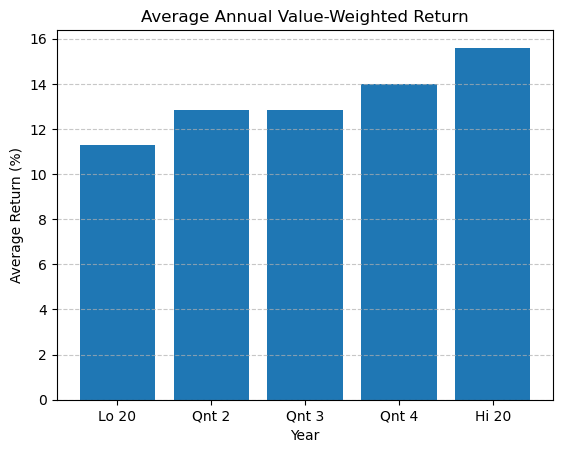

In [102]:
#average annual return across all 5 portfolios
#plt.plot(port_beta.columns,port_beta.mean(axis=0))
plt.bar(port_beta.columns,port_beta.mean(axis=0))
plt.title("Average Annual Value-Weighted Return")
plt.ylabel("Average Return (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Year");

There appears to be a generally positive relationship between beta and average annual returns, with the highest beta portfolio generating the highest returns and the lowest beta portfolio generating the lowest returns. This pattern is largely consistent with CAPM's prediction that a higher beta should be compensated with higher expected returns.

### Part b

In [89]:
data1963 = port_beta.fillna(0).loc['1963':]
data1963.index = data1963.index.to_timestamp()
data1963=data1963.resample('YE').last()
data1963=data1963.div(100)
inv_value = (1 + data1963).cumprod()

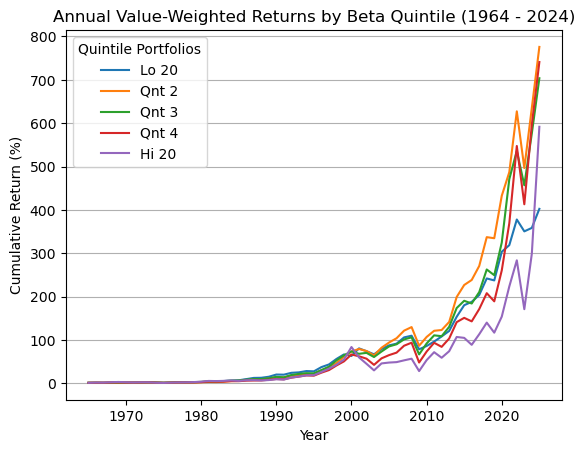

In [105]:
sns.lineplot(data=inv_value, dashes=False)
plt.title("Annual Value-Weighted Returns by Beta Quintile (1964 - 2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return (%)")
plt.grid(axis='y')
plt.legend(title="Quintile Portfolios")
plt.show()

Qnt 2 appears to have had the best performance over the entire period (1964 - 2024). The lowest beta portfolio (Lo 20) has the lowest cumulative return at ~400%. The highest beta portfolio had the second lowest cumulative return at ~600%. The middle quantiles (Qnt 2, 3, and 4) seemed to have outperformed the low and high beta portfolios, all exceeding 700%.

    2. In this question, you will explore the Fama-French SIZE factor. In order to do this, you will need to download the 'Portfolios_Formed_on_ME' file from Ken French's website at Dartmouth College. Specifically, you will need to use the second dataset (index [1]), which contains the monthly returns on two sets of portfolios formed on the previous year's market capitalization . You will need to use the decile portfolios (Lo10 through Hi10) for your analysis.
        a. Create a DF labeled alphas85 to store the intercepts and pvalues from the CAPM model for the ten portfolios over the sample period 1926 - 1985. Create a plot of the intercepts. How do you interpret the results?
        b. Repeat the analysis in part a, but this time using the sample period 1986 - 2024. How do you interpret the results?
        c. What can you conclude based on the evidence in part a) and part b).
        d. Are the returns on the ten portfolios formed on size concentrated in a specific month? Use statistics and plots to justify your answer.

In [128]:
port_me= pdr.get_data_famafrench('Portfolios_Formed_on_ME', start=dt.datetime(1900,1,1))[1]
port_me=port_me.iloc[:,9:]
#print(port_me['DESCR'])

In [129]:
port_me.index = port_me.index.to_timestamp()
port_me=port_me.resample('ME').last()

In [130]:
ff_factors = pdr.get_data_famafrench('F-F_Research_Data_Factors',start=dt.datetime(1900,1,1))[0]
ff_factors.index = ff_factors.index.to_timestamp(how='end').normalize()

In [131]:
port_me = port_me.join(ff_factors)
#port_me

In [132]:
port_me_85 = port_me.loc['1926':'1985']
port_me_24 = port_me.loc['1986':]

In [133]:
def capm(data, port):
    data['Excess'] = data[port] - data['RF']
    model = smf.ols('Excess ~ Q("Mkt-RF")', data=data, missing="drop").fit()
    #summary = model.summary(yname = 'MSFT Return', xname = ['Alpha', 'MKTRF Beta'])
    return model

In [134]:
portfolios = ["Lo 10", "Dec 2", "Dec 3", "Dec 4", "Dec 5", "Dec 6", "Dec 7", "Dec 8", "Dec 9", "Hi 10"]
alphas85 = pd.DataFrame(index=portfolios, columns=['alpha', 'p_value'])
alphas24 = pd.DataFrame(index=portfolios, columns=['alpha', 'p_value'])
for port in portfolios:
    model = capm(port_me_85, port)
    model2 = capm(port_me_24, port)
    alphas85.loc[port, 'alpha'] = model.params[0]  
    alphas85.loc[port, 'p_value'] = model.pvalues[0]
    alphas24.loc[port, 'alpha'] = model2.params[0]  
    alphas24.loc[port, 'p_value'] = model2.pvalues[0]

### Part a

Text(0, 0.5, 'Intercept')

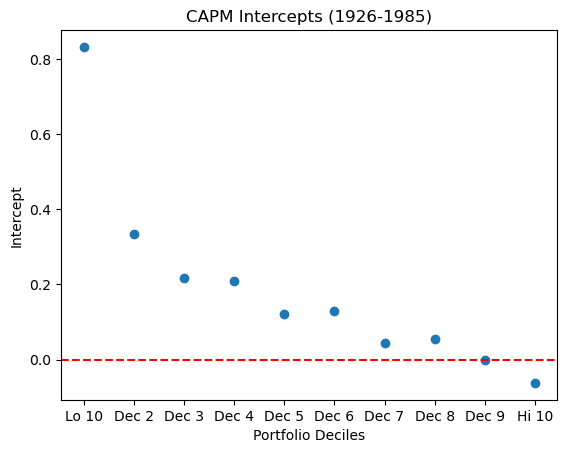

In [135]:
plt.scatter(alphas85.index, alphas85['alpha'].astype(float))
plt.axhline(y=0, color='red', linestyle='--')
plt.title('CAPM Intercepts (1926-1985)')
plt.xticks()
plt.xlabel('Portfolio Deciles')
plt.ylabel('Intercept')

The graph shows a strong size effect during this period. The smallest portfolios (Lo10) has the largest positive alpha of ~0.8, indicating they significantly outperformed what CAPM would predict based on their beta. The intercepts decrease as market cap increases, with the largest stocks (Hi10) showing negative alpha. This suggests that the smaller portfolios earned abnormal returns not explained by their market risk and that size was a significant factor in stock returns during this period.

### Part b

Text(0, 0.5, 'Intercept')

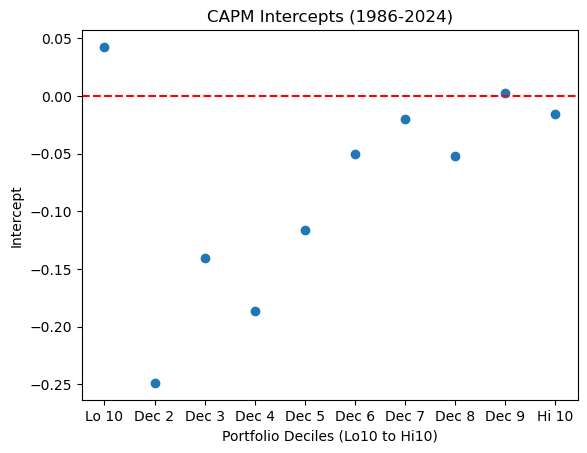

In [136]:
plt.scatter(alphas24.index, alphas24['alpha'].astype(float))
plt.title('CAPM Intercepts (1986-2024)')
plt.axhline(y=0, color='red', linestyle='--')
plt.xticks()
plt.xlabel('Portfolio Deciles (Lo10 to Hi10)')
plt.ylabel('Intercept')

The intercepts for most portfolios (Dec 2 through Dec 8) are negative, suggesting they underperformed relative to their CAPM-predicted returns. The largest portfolios (Dec 9 and Hi 10) have intercepts close to zero, indicating they performed in line with CAPM predictions. 

Most of the smaller and mid-sized portfolios (Dec 2 through Dec 7) show significant negative alphas, with Dec 2 being the worst at -0.25. As we move toward larger portfolios (Dec 8, Dec 9, Hi 10), the alphas improve and approach zero.

Only the smallest decile (Lo 10) shows a positive alpha.

### Part c

 The size effect has fundamentally changed over time. In the period from 1926 to 1985, smaller portfolios strongly outperformed with high positive alphas that decreased as firm size increased. In the more recent period from 1986 to 2024, this pattern reversed, with most small and mid-cap portfolios showing significant negative alphas.

 From this, we can infer that the tendency for smaller firms to outperform larger firms in terms of returns has significantly reversed over time. This shift suggests that market dynamics have changed, with small-mid companies underperforming relative to their larger counterparts in more recent decades. Smaller firms generally face higher risks, and during periods of market turbulence or economic downturns, their vulnerability becomes more pronounced. Investors may have shifted toward larger, more stable companies.

### Part d

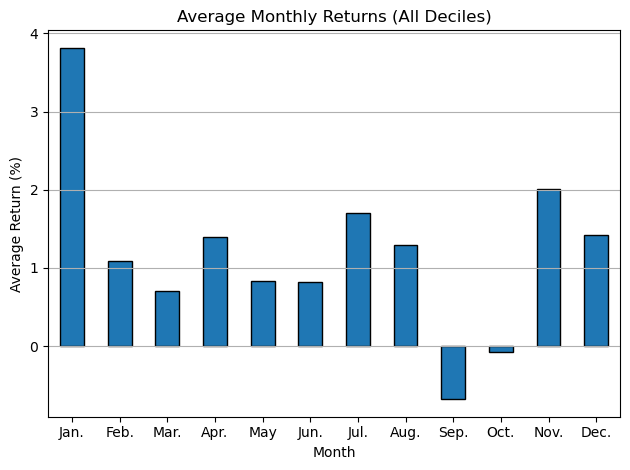

Standard Deviation of Average Monthly Returns
Date
1     2.535598
2     0.465598
3     0.073852
4     0.124171
5     0.313766
6     0.104172
7     0.114058
8     0.108333
9     0.311506
10    0.494085
11    0.296387
12    0.542171
dtype: float64


In [140]:
monthly_grouped = port_me.iloc[:,:10].groupby(port_me.index.month)
monthly_avg_returns = monthly_grouped.mean().mean(axis=1)

monthly_avg_returns.plot(kind='bar',edgecolor='black')
plt.title('Average Monthly Returns (All Deciles)')
plt.xlabel('Month')
plt.ylabel('Average Return (%)')
plt.xticks(ticks=range(12), labels=[
    'Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.',
    'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.'], rotation=0)
plt.grid(axis='y') 
plt.tight_layout()
plt.show()

print("Standard Deviation of Average Monthly Returns")
print(monthly_grouped.mean().std(axis=1))

This bar chart shows that returns are not evenly distributed across each month. January shows higher returns, nearly reaching 4%. September and October show negative average monthly returns. This shows that size premium is highly concentrated in January and isn't distributed throughout the year.

The standard deviation of the average of these monthly returns shows that January also has the highest variability in returns. The high standard deviation in January indicates that not only are returns typically higher in that month, but they can also vary substantially from year to year.

### PART II

    3. a. Display the results obtained from applying the Fama-French three-factor model to Berkshire Hathaway's daily returns over its entire history (ticker is 'BRK-A'). What is Berkshire's annualized alpha over its entire history? Comment on Berkshire's portfolio allocation.
    b. Create a DataFrame named coefs to store the coefficient estimates from applying the Fama-French three-factor model to Berkshire Hathaway's returns using a three-year rolling window (Assume there are 250 trading days in a year). Comment on how Berkshire's alpha and betas changed over the past four decades? Use statistics and plots to justify your answer.
    c. What was the most successful 3-year period in Berkshire's history?

### PART III

    4. Implement the following three algorithmic trading strategies, using the monthly market factor from Ken French's website: 
        1) a 12-month SMA strategy (SMA(12)). Specifically, buy the market when the closing price crosses SMA(12) from below and sell it when the closing price crosses SMA(12) from above.
        2) The same strategy as in 1), but this time you can invest in the risk-free asset if you are not invested in the market.
        3) a 12-month SMA strategy where you short sell. Specifically, buy the market when the closing price is above the SMA(12) and sell it when the closing price is below the SMA(12).
    a. Compare these three strategies with a fouth strategy: buying and holding the market. Which was the best performer?
    b. Which of the four strategies was the best investment?
     (Use statistics and plots to justify your answers.) 